**Vehical Resale Price Prediction**

Team
- Praveen Kumar Gonuguntla
- Divya Medapureddy
- Neha Vunnam


In [299]:
pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [300]:
pip install google-cloud-bigquery pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [301]:
import pandas as pd
from google.cloud import bigquery
import numpy as np
import pandas as pd
from pyspark.sql.functions import sum, when, col
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.sql.functions import col
import matplotlib.pyplot as plt


# Data Cleaning

### need to have json file "turing-flow-386816-558e6b29f37e.json" avalible to acess table from big query

In [344]:
key_path = '/content/turing-flow-386816-558e6b29f37e.json'
client = bigquery.Client.from_service_account_json(key_path)
query = '''
SELECT *
FROM `turing-flow-386816.6041.raw`
'''

query_job = client.query(query)
df = query_job.to_dataframe()


In [345]:
df

,Maker,_Genmodel,_Genmodel_ID,Adv_ID,Adv_year,Adv_month,Color,Reg_year,Bodytype,Runned_Miles,...,Average_mpg,Top_speed,Seat_num,Door_num,inflation,Sales,last_produced_year,Entree_Price,Gas_Emission,Fuel_Price
0,Bentley,Arnage,10_1,10_1$$15,2018,4,Black,2000,Saloon,61500,...,None,None,<NA>,<NA>,2.5,0,2012,174400,#N/A,2.873
1,Bentley,Arnage,10_1,10_1$$17,2018,2,None,2003,Saloon,35000,...,None,None,<NA>,<NA>,2.2,0,2012,174400,456,2.705
2,Bentley,Arnage,10_1,10_1$$20,2018,4,Blue,2003,Saloon,92000,...,None,None,5,<NA>,2.5,0,2012,174400,456,2.873
3,Bentley,Azure,10_2,10_2$$1,2018,4,Red,1995,Convertible,78000,...,None,None,<NA>,<NA>,2.5,0,2011,#N/A,#N/A,2.873
4,Bentley,Bentayga,10_3,10_3$$5,2018,8,Black,2016,SUV,33000,...,None,None,<NA>,5,2.7,526,2020,160200,292,2.914
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268247,Volkswagen,Golf SV,95_17,95_17$$387,2018,5,None,2017,MPV,10,...,67.3 mpg,119 mph,5,5,2.8,0,#N/A,#N/A,#N/A,3.244
268248,Volkswagen,Golf SV,95_17,95_17$$430,2018,5,Blue,2018,MPV,4,...,67.3 mpg,119 mph,5,5,2.8,0,#N/A,#N/A,#N/A,3.244
268249,Volkswagen,Golf SV,95_17,95_17$$434,2018,4,Grey,2018,MPV,20,...,67.3 mpg,119 mph,5,5,2.5,0,#N/A,#N/A,#N/A,3.096
268250,Volkswagen,Golf SV,95_17,95_17$$209,2018,4,Grey,2018,MPV,5000,...,68.9 mpg,119 mph,5,5,2.5,0,#N/A,#N/A,#N/A,3.096


striping the column names for unnecessery characters

In [346]:
# Remove underscores from start and end of column names
df.rename(columns=lambda x: x.strip('_'), inplace=True)

Replace zeros with NA

In [347]:
# Replace 0 with NaN
df.replace(0, np.nan, inplace=True)

In [348]:
# Calculate the sum of NaN values in each column
nan_sum = df.isna().sum()

# Print the sum of NaN values in each column
print(nan_sum)

Maker                     0
Genmodel                  0
Genmodel_ID               0
Adv_ID                    0
Adv_year                  0
Adv_month                 0
Color                 21875
Reg_year                  7
Bodytype                954
Runned_Miles           1055
Engin_size             2064
Gearbox                 167
Fuel_type               409
Price                  1145
Engine_power          31810
Annual_Tax            46673
Wheelbase             35421
Height                28745
Width                 28079
Length                27888
Average_mpg           41932
Top_speed             43601
Seat_num               6474
Door_num               4553
inflation                22
Sales                 74429
last_produced_year        0
Entree_Price              0
Gas_Emission              0
Fuel_Price                0
dtype: int64


In [306]:
# it is not possible to replace color so dropping it
df.drop("Color",inplace=True,axis=1)

In [307]:

# Define the columns to process
columns_to_process = ['Runned_Miles', 'Annual_Tax',"Average_mpg","Top_speed","Entree_Price","Gas_Emission"]

# Remove non-numeric characters from the specified columns
df[columns_to_process] = df[columns_to_process].replace('[^0-9.]', '', regex=True)

In [308]:
# Define the columns in which to replace values
columns_to_replace = ['Top_speed',"Runned_Miles","Average_mpg"]

# Replace values in the specified columns
df[columns_to_replace] = df[columns_to_replace].apply(lambda x: x.str.replace('mpg', '').str.replace(' ', '').str.replace('\*', '').str.replace('mph', '').str.replace('mile', ''))



<ipython-input-308-eef65f9f464d>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df[columns_to_replace] = df[columns_to_replace].apply(lambda x: x.str.replace('mpg', '').str.replace(' ', '').str.replace('\*', '').str.replace('mph', '').str.replace('mile', ''))


In [309]:
# Replace blanks with NaN
df.replace('', np.nan, inplace=True)

# replace from values with same carid in different row

In [310]:
cols = ['Seat_num', 'Door_num', 'Entree_Price']
col_dict = {col: dict(df.loc[df[col].notnull(), ['Genmodel_ID', col]].values) for col in cols}

for col in cols:
    df[col] = df[col].fillna(df['Genmodel_ID'].map(col_dict[col]))


In [311]:
# not posible to predict Last produced year and it have maney na so droping it
df = df.drop(['last_produced_year'], axis=1)

Droping rest of rows to that have NA's

In [312]:
df.dropna(inplace=True)

<ipython-input-316-52514b797334>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


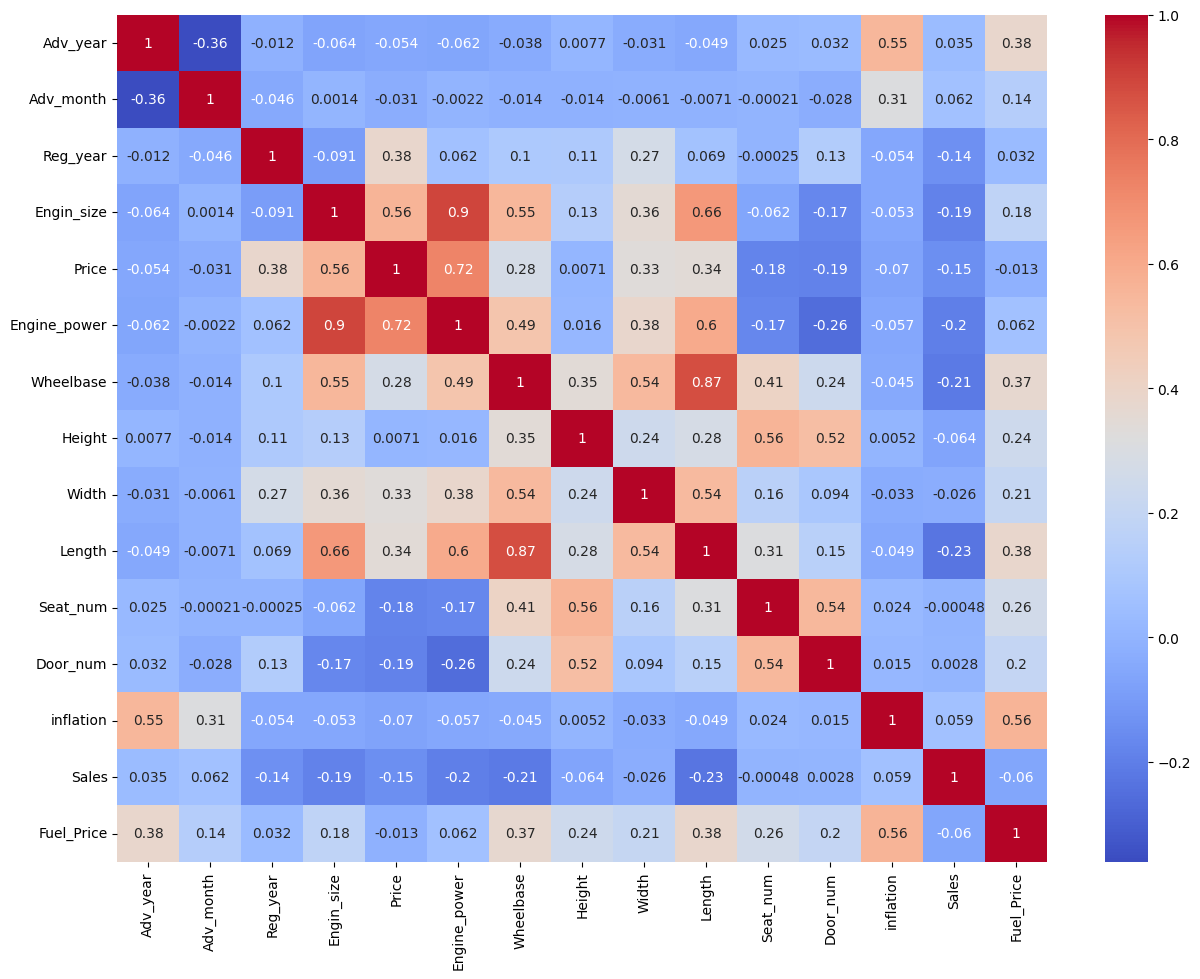

In [316]:
import seaborn as sns
corr_matrix = df.corr()

# increase the plot size
plt.figure(figsize=(15, 11))

# plot the correlation heatmap using seaborn
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

# display the plot
plt.show()

cleaned df is saved to CSV and upoded to big query so that tableau also can acess the data

# Building ML Models

In [ ]:
#df.to_csv("cars.csv")

In [317]:
# acessing the key file
key_path = '/content/turing-flow-386816-558e6b29f37e.json'
client = bigquery.Client.from_service_account_json(key_path)


In [319]:
# query to retrive data
query = '''
SELECT *
FROM `turing-flow-386816.6041.cars`
'''


In [320]:
# running the query
query_job = client.query(query)
df = query_job.to_dataframe()


In [321]:
# still there happend to be 2 blank cells so finning it with 0
df['Annual_tax'] = df['Annual_tax'].fillna(0).astype(int)

loding data to spark instance

In [322]:
from pyspark.sql import SparkSession
import pandas as pd

# Create a SparkSession object
spark = SparkSession.builder.appName('pandas_to_spark').getOrCreate()



# Convert the Pandas DataFrame to a Spark DataFrame
spark_df = spark.createDataFrame(df)

# Show the first 5 rows of the Spark DataFrame
spark_df.show()


+-------------+-----+--------+-----------+----------+--------+---------+--------+-----+--------+------------+----------+---------+---------+-----+------------+----------+---------+------+-----+------+-----------+---------+--------+--------+---------+-----+-------------+------------+-----------+
|int64_field_0|Maker|Genmodel|Genmodel_id|    Adv_id|Adv_year|Adv_month|Reg_year|Years|Bodytype|Runned_miles|Engin_size|  Gearbox|Fuel_type|Price|Engine_power|Annual_tax|Wheelbase|Height|Width|Length|Average_mpg|Top_speed|Seat_num|Door_num|Inflation|Sales|Entr__e_price|Gas_emission|Fuel_type_1|
+-------------+-----+--------+-----------+----------+--------+---------+--------+-----+--------+------------+----------+---------+---------+-----+------------+----------+---------+------+-----+------+-----------+---------+--------+--------+---------+-----+-------------+------------+-----------+
|        33384| Ford|  Galaxy|      29_19|29_19$$485|    2018|        5|    2017|    1|     MPV|        8410|   

In [323]:
# no of rows
spark_df.count()

188358

In [324]:
# check if we still have any null values
from pyspark.sql.functions import col, sum, when

na_counts_df = spark_df.select([sum(when(col(c).like('NA'), 1)).alias(c) for c in spark_df.columns])

na_counts_df.show()


+-------------+-----+--------+-----------+------+--------+---------+--------+-----+--------+------------+----------+-------+---------+-----+------------+----------+---------+------+-----+------+-----------+---------+--------+--------+---------+-----+-------------+------------+-----------+
|int64_field_0|Maker|Genmodel|Genmodel_id|Adv_id|Adv_year|Adv_month|Reg_year|Years|Bodytype|Runned_miles|Engin_size|Gearbox|Fuel_type|Price|Engine_power|Annual_tax|Wheelbase|Height|Width|Length|Average_mpg|Top_speed|Seat_num|Door_num|Inflation|Sales|Entr__e_price|Gas_emission|Fuel_type_1|
+-------------+-----+--------+-----------+------+--------+---------+--------+-----+--------+------------+----------+-------+---------+-----+------------+----------+---------+------+-----+------+-----------+---------+--------+--------+---------+-----+-------------+------------+-----------+
|         null| null|    null|       null|  null|    null|     null|    null| null|    null|        null|      null|   null|     n

one hot encoding categorical values

In [325]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.sql.functions import col

# List of categorical columns
categorical_columns = ["Bodytype", "Gearbox","Fuel_type"]

# Pipeline stages for indexing and encoding
stages = []

for column in categorical_columns:
    # Indexing the categorical column
    indexer = StringIndexer(inputCol=column, outputCol=f"{column}Index")
    stages.append(indexer)

    # One-hot encoding
    encoder = OneHotEncoder(inputCol=f"{column}Index", outputCol=f"{column}Vec")
    stages.append(encoder)

# Create the pipeline
pipeline = Pipeline(stages=stages)

# Fit and transform the pipeline
encoded_df = pipeline.fit(spark_df).transform(spark_df)

# Selecting the original columns and encoded columns
columns_to_select = spark_df.columns + [f"{column}Vec" for column in categorical_columns]
result_df = encoded_df.select(*columns_to_select)

# Display the resulting DataFrame
result_df.show(truncate=False)


+-------------+-----+--------+-----------+----------+--------+---------+--------+-----+--------+------------+----------+---------+---------+-----+------------+----------+---------+------+-----+------+-----------+---------+--------+--------+---------+-----+-------------+------------+-----------+-------------+----------+-------------+
|int64_field_0|Maker|Genmodel|Genmodel_id|Adv_id    |Adv_year|Adv_month|Reg_year|Years|Bodytype|Runned_miles|Engin_size|Gearbox  |Fuel_type|Price|Engine_power|Annual_tax|Wheelbase|Height|Width|Length|Average_mpg|Top_speed|Seat_num|Door_num|Inflation|Sales|Entr__e_price|Gas_emission|Fuel_type_1|BodytypeVec  |GearboxVec|Fuel_typeVec |
+-------------+-----+--------+-----------+----------+--------+---------+--------+-----+--------+------------+----------+---------+---------+-----+------------+----------+---------+------+-----+------+-----------+---------+--------+--------+---------+-----+-------------+------------+-----------+-------------+----------+----------

## feature selection
- considered featurs in the order of corelation
- by comparing multicolinearity amonf featurs
- added iteratively one after another
- degree 2 is giving good performace

In [326]:
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(
    inputCols=[ "Years","Entr__e_price","Runned_miles","BodytypeVec","Width","Seat_num","Door_num","Sales"],
    outputCol="features")

In [327]:
n_df=assembler.transform(result_df)

In [328]:
model_df=n_df.select("features","price")

In [329]:
# spliting the data
training_df,test_df=model_df.randomSplit([0.7,0.3])

Polynomial regression

In [330]:
from pyspark.ml.feature import PolynomialExpansion
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator



# Define the degree of the polynomial expansion
degree = 2

# Define the features column
features_col = "features"

# Create a PolynomialExpansion transformer
poly_expansion = PolynomialExpansion(degree=degree, inputCol=features_col, outputCol="poly_features")

# Create a LinearRegression estimator
lr = LinearRegression(featuresCol="features", labelCol="price")

# Create a pipeline with PolynomialExpansion and LinearRegression
pipeline = Pipeline(stages=[poly_expansion, lr])


# Fit the pipeline on the training data
model = pipeline.fit(training_df)

# Make predictions on the training data
train_predictions = model.transform(training_df)

# Evaluate the model's performance on the training data
train_evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="r2")
train_r2 = train_evaluator.evaluate(train_predictions)

# Make predictions on the test data
test_predictions = model.transform(test_df)

# Evaluate the model's performance on the test data
test_evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="r2")
test_r2 = test_evaluator.evaluate(test_predictions)

# Print the R2 for both training and test sets
print("R2 - Training Set:", train_r2)
print("R2 - Test Set:", test_r2)

R2 - Training Set: 0.7176492471675262
R2 - Test Set: 0.7161291530015803


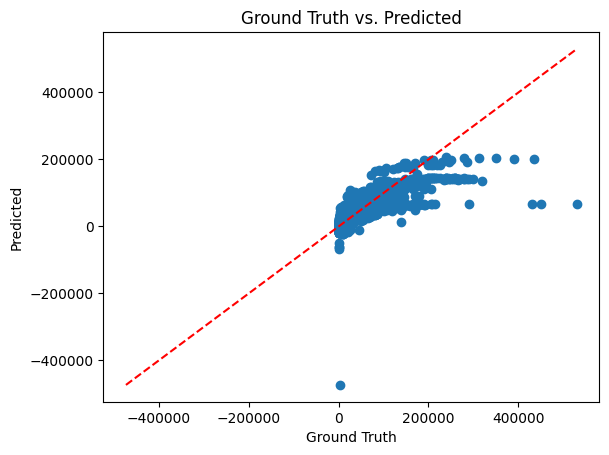

In [331]:



# Extract the ground truth and predicted values
ground_truth = test_predictions.select("price").rdd.flatMap(lambda x: x).collect()
predicted = test_predictions.select("prediction").rdd.flatMap(lambda x: x).collect()

# Create a scatter plot of ground truth vs predicted values
plt.scatter(ground_truth, predicted)
plt.xlabel("Ground Truth")
plt.ylabel("Predicted")
plt.title("Ground Truth vs. Predicted")

# Add a line representing the ideal prediction
min_value = min(min(ground_truth), min(predicted))
max_value = max(max(ground_truth), max(predicted))
plt.plot([min_value, max_value], [min_value, max_value], 'r--')

plt.show()


Decision tree regressor

In [332]:
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Create a DecisionTreeRegressor
dt = DecisionTreeRegressor(featuresCol="features", labelCol="price")

# Create a pipeline with PolynomialExpansion and DecisionTreeRegressor
pipeline = Pipeline(stages=[poly_expansion, dt])

# Fit the pipeline on the training data
model = pipeline.fit(training_df)

# Make predictions on the training data
train_predictions = model.transform(training_df)

# Evaluate the model's performance on the training data
train_evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="r2")
train_r2 = train_evaluator.evaluate(train_predictions)

# Make predictions on the test data
test_predictions = model.transform(test_df)

# Evaluate the model's performance on the test data
test_evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="r2")
test_r2 = test_evaluator.evaluate(test_predictions)

# Print the R2 for both training and test sets
print("R2 - Training Set:", train_r2)
print("R2 - Test Set:", test_r2)



R2 - Training Set: 0.8201601218552734
R2 - Test Set: 0.8138272196647652


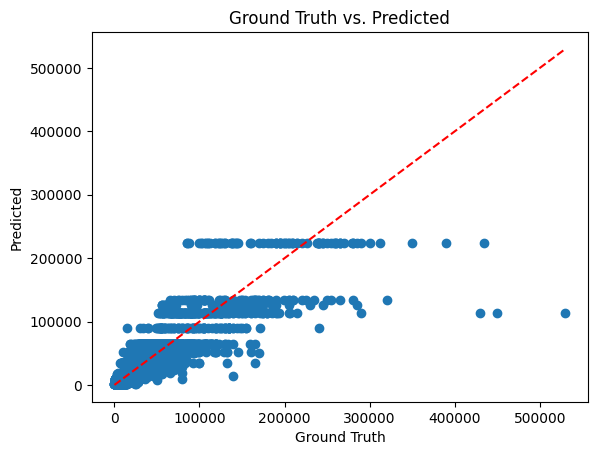

In [333]:
import numpy as np
import matplotlib.pyplot as plt

# Extract the ground truth and predicted values
ground_truth = test_predictions.select("price").rdd.flatMap(lambda x: x).collect()
predicted = test_predictions.select("prediction").rdd.flatMap(lambda x: x).collect()

# Create a scatter plot of ground truth vs predicted values
plt.scatter(ground_truth, predicted)
plt.xlabel("Ground Truth")
plt.ylabel("Predicted")
plt.title("Ground Truth vs. Predicted")

# Add a line representing the ideal prediction
min_value = min(min(ground_truth), min(predicted))
max_value = max(max(ground_truth), max(predicted))
plt.plot([min_value, max_value], [min_value, max_value], 'r--')

plt.show()


Random forest regressor

In [335]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Create a RandomForestRegressor
rf = RandomForestRegressor(featuresCol="features", labelCol="price")

# Create a pipeline with PolynomialExpansion and RandomForestRegressor
pipeline = Pipeline(stages=[poly_expansion, rf])

# Fit the pipeline on the training data
model = pipeline.fit(training_df)

# Make predictions on the training data
train_predictions = model.transform(training_df)

# Evaluate the model's performance on the training data
train_evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="r2")
train_r2 = train_evaluator.evaluate(train_predictions)

# Make predictions on the test data
test_predictions = model.transform(test_df)

# Evaluate the model's performance on the test data
test_evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="r2")
test_r2 = test_evaluator.evaluate(test_predictions)

# Print the R2 for both training and test sets
print("R2 - Training Set:", train_r2)
print("R2 - Test Set:", test_r2)


R2 - Training Set: 0.8289538491908853
R2 - Test Set: 0.8368811171506694


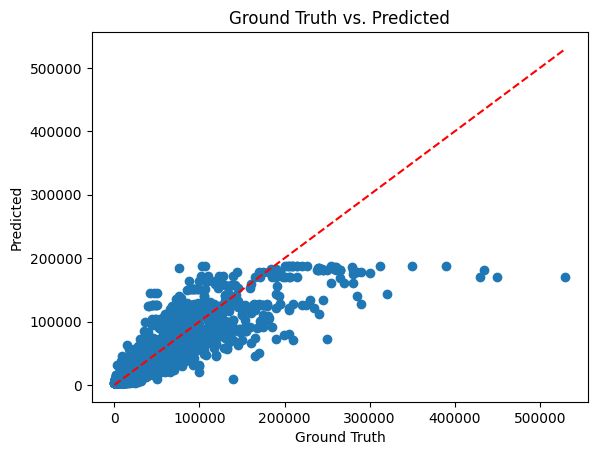

In [336]:
import numpy as np
import matplotlib.pyplot as plt

# Extract the ground truth and predicted values
ground_truth = test_predictions.select("price").rdd.flatMap(lambda x: x).collect()
predicted = test_predictions.select("prediction").rdd.flatMap(lambda x: x).collect()

# Create a scatter plot of ground truth vs predicted values
plt.scatter(ground_truth, predicted)
plt.xlabel("Ground Truth")
plt.ylabel("Predicted")
plt.title("Ground Truth vs. Predicted")

# Add a line representing the ideal prediction
min_value = min(min(ground_truth), min(predicted))
max_value = max(max(ground_truth), max(predicted))
plt.plot([min_value, max_value], [min_value, max_value], 'r--')

plt.show()


Gradient Boosting regressor

In [337]:
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Create a GBTRegressor
gbt = GBTRegressor(featuresCol="features", labelCol="price")

# Create a pipeline with PolynomialExpansion and GBTRegressor
pipeline = Pipeline(stages=[poly_expansion, gbt])

# Fit the pipeline on the training data
model = pipeline.fit(training_df)

# Make predictions on the training data
train_predictions = model.transform(training_df)

# Evaluate the model's performance on the training data
train_evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="r2")
train_r2 = train_evaluator.evaluate(train_predictions)

# Make predictions on the test data
test_predictions = model.transform(test_df)

# Evaluate the model's performance on the test data
test_evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="r2")
test_r2 = test_evaluator.evaluate(test_predictions)

# Print the R2 for both training and test sets
print("R2 - Training Set:", train_r2)
print("R2 - Test Set:", test_r2)


R2 - Training Set: 0.8858691207902561
R2 - Test Set: 0.8788800299350499


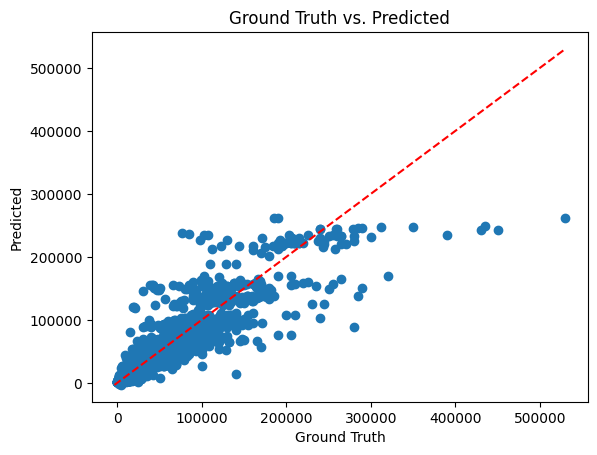

In [338]:
import numpy as np
import matplotlib.pyplot as plt

# Extract the ground truth and predicted values
ground_truth = test_predictions.select("price").rdd.flatMap(lambda x: x).collect()
predicted = test_predictions.select("prediction").rdd.flatMap(lambda x: x).collect()

# Create a scatter plot of ground truth vs predicted values
plt.scatter(ground_truth, predicted)
plt.xlabel("Ground Truth")
plt.ylabel("Predicted")
plt.title("Ground Truth vs. Predicted")

# Add a line representing the ideal prediction
min_value = min(min(ground_truth), min(predicted))
max_value = max(max(ground_truth), max(predicted))
plt.plot([min_value, max_value], [min_value, max_value], 'r--')

plt.show()


## conclusion
Gradient boosting is the best performing model to predict vehicle resale price